In [ ]:
import pandas as pd

%load_ext autoreload
%autoreload 2
from vm_placement.data_handling import Data
from vm_placement.data_handling.sorting import calculate_scarcity_ratio, sort_by_scarcity_ratio
from vm_placement.algorithms.first_fit import FirstFitAlgo, FirstFitDivideAlgo
from vm_placement.data_handling.processing import resource_columns
from vm_placement.algorithms.best_fit import BestFitAlgo

## Data Loading
We pretend all servers have the same capacities: 64 GB vCPU, 512 GB memory, 2048 GB storage.

In [4]:
server_capacity = pd.DataFrame({
    'vCPU': [64],
    'Memory': [512],
    'Storage': [2048]
})
data = Data(
    vm_filepath='data/vm_data.csv',
    server_specs=server_capacity,
    n_servers=150  ## We allow more than enough servers to solve the problem
)

In [5]:
data.vm_data

,vCPU,Memory,Storage,Class
0,4,8.0,10.23,1
1,8,16.0,10.23,1
2,2,4.0,32.00,1
3,2,4.0,32.00,1
4,4,8.0,10.23,1
...,...,...,...,...
859,2,8.0,2048.00,3
860,4,4.0,32.00,3
861,4,4.0,32.00,3
862,4,4.0,32.00,3


In [6]:
data.server_data.head(3)

,vCPU,Memory,Storage
0,64,512,2048
1,64,512,2048
2,64,512,2048


# Nominal case
## 1) First-fit
Each VM is taken one at a time, and we try to fit it in the first server where it can fit.

### a) No VM sorting
Not sorting the VMs is less optimal, but can be used online.

864it [00:25, 34.23it/s] 


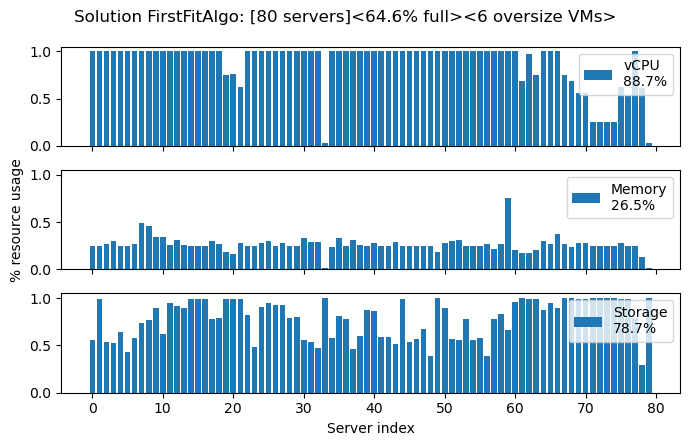


Oversize VMs:
     vCPU  Memory  Storage  Class
216  16.0    32.0   2074.0    2.0
298   4.0    32.0   3152.0    2.0
367   2.0     8.0   4096.0    2.0
752   2.0     8.0   4096.0    3.0
856   2.0     8.0   4096.0    3.0
857   2.0     8.0   4096.0    3.0


In [7]:
solution_first_fit = FirstFitAlgo().solve(data.vm_data, data.server_data)
solution_first_fit.display()

### b) Sorting the VMS
Sorting the VMs by decreasing order of resource requirements allows for placing the bigger ones first. The difficulty relies in finding what quantity to sort them by.

#### Scarcity Ratio
The scarcity ratio is calculated for each resource (CPU, Memory, Storage) and expresses the following:
> In what proportion does the average VM fill the average server for that specific resource?

In [8]:
scarcity_ratio = calculate_scarcity_ratio(data)
scarcity_ratio

vCPU       0.082610
Memory     0.024768
Storage    0.085066
dtype: float64

In [9]:
sorted_vms = sort_by_scarcity_ratio(data.vm_data, scarcity_ratio)
sorted_vms

,vCPU,Memory,Storage,Class
770,32,64.0,1043.00,3
769,32,64.0,1043.00,3
768,32,64.0,1043.00,3
766,32,64.0,1043.00,3
378,32,64.0,1042.67,2
...,...,...,...,...
782,1,2.0,32.00,3
780,1,2.0,32.00,3
725,1,1.0,32.00,3
781,1,1.0,32.00,3


864it [00:40, 21.54it/s]


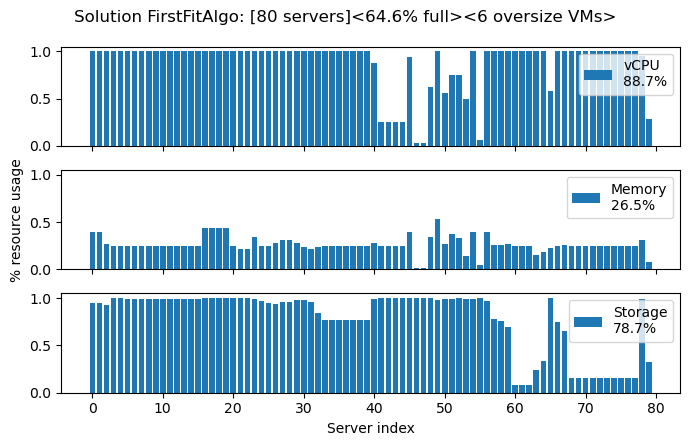


Oversize VMs:
     vCPU  Memory  Storage  Class
216  16.0    32.0   2074.0    2.0
367   2.0     8.0   4096.0    2.0
752   2.0     8.0   4096.0    3.0
856   2.0     8.0   4096.0    3.0
857   2.0     8.0   4096.0    3.0
298   4.0    32.0   3152.0    2.0


In [10]:
first_fit = FirstFitAlgo()
solution = first_fit.solve(sorted_vms, data.server_data)
solution.display()

#### Sorting by Storage
Results are much worse

864it [00:41, 20.86it/s]


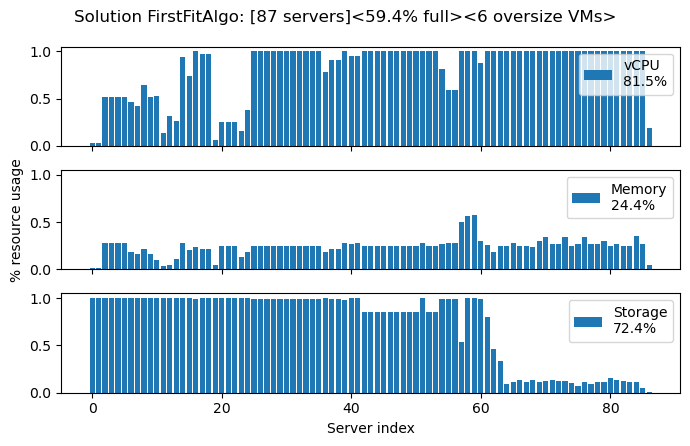


Oversize VMs:
     vCPU  Memory  Storage  Class  weighted_resources
367   2.0     8.0   4096.0    2.0            0.092293
857   2.0     8.0   4096.0    3.0            0.092293
856   2.0     8.0   4096.0    3.0            0.092293
752   2.0     8.0   4096.0    3.0            0.092293
298   4.0    32.0   3152.0    2.0            0.084043
216  16.0    32.0   2074.0    2.0            0.092634


In [11]:
sorted_storage_vms = data.vm_data.sort_values('Storage', ascending=False)
first_fit = FirstFitAlgo()
solution = first_fit.solve(sorted_storage_vms, data.server_data)
solution.display()

## 2) Best-Fit
In the Best-fit algorithm, we place the VMs one at a time, however instead of placing them in the first server where they fit, we place them where they will leave the least amount of space.

### Without sorting the VMs
Even if we don't sort the VMs beforehand, we still need a comparison criterion to decide the "best fit".
This is why the consturctor of the BestFitAlgo needs a criterion

864it [00:32, 26.49it/s]


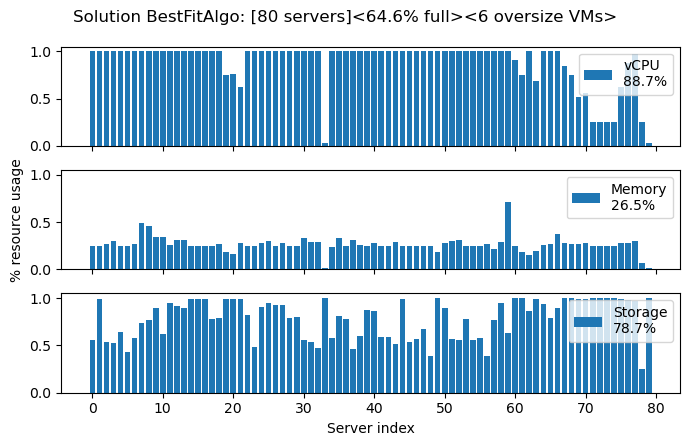


Oversize VMs:
     vCPU  Memory  Storage  Class  weighted_resources
216  16.0    32.0   2074.0    2.0            0.092634
298   4.0    32.0   3152.0    2.0            0.084043
367   2.0     8.0   4096.0    2.0            0.092293
752   2.0     8.0   4096.0    3.0            0.092293
856   2.0     8.0   4096.0    3.0            0.092293
857   2.0     8.0   4096.0    3.0            0.092293


In [12]:
best_fit = BestFitAlgo(criterion='weighted_resources')
solution = best_fit.solve(data.vm_data, data.server_data, scarcity_ratio)
solution.display()

### b) Using the scarcity ratio for sorting

864it [00:52, 16.42it/s]


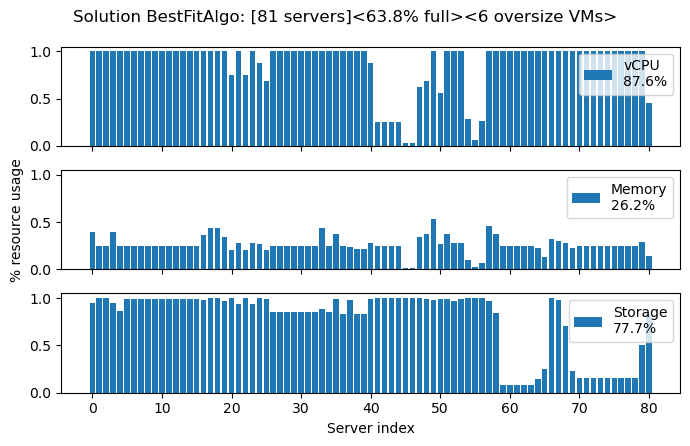


Oversize VMs:
     vCPU  Memory  Storage  Class
216  16.0    32.0   2074.0    2.0
367   2.0     8.0   4096.0    2.0
752   2.0     8.0   4096.0    3.0
856   2.0     8.0   4096.0    3.0
857   2.0     8.0   4096.0    3.0
298   4.0    32.0   3152.0    2.0


In [13]:
sorted_vms = sort_by_scarcity_ratio(data.vm_data, scarcity_ratio)
best_fit = BestFitAlgo(criterion='weighted_resources')
solution = best_fit.solve(sorted_vms, data.server_data, scarcity_ratio)
solution.display()

### c) Sorting by resources
Instead of using the scarcity index, we can sort by specific resource types. Memory is the least scarce, so we sort it with the least priority.
#### Sorting by storage first

864it [00:52, 16.41it/s]


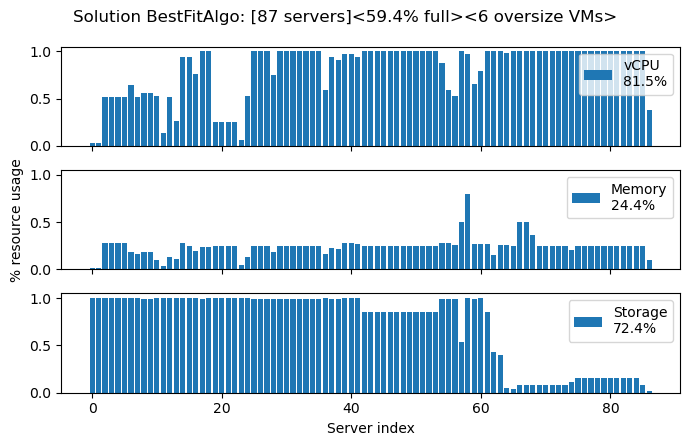


Oversize VMs:
     vCPU  Memory  Storage  Class  weighted_resources
367   2.0     8.0   4096.0    2.0            0.092293
752   2.0     8.0   4096.0    3.0            0.092293
856   2.0     8.0   4096.0    3.0            0.092293
857   2.0     8.0   4096.0    3.0            0.092293
298   4.0    32.0   3152.0    2.0            0.084043
216  16.0    32.0   2074.0    2.0            0.092634


In [15]:
criterion = ['Storage', 'vCPU', 'Memory']
sorted_vms = data.vm_data.sort_values(criterion, ascending=False)
best_fit = BestFitAlgo(criterion=criterion)
solution = best_fit.solve(sorted_vms, data.server_data, scarcity_ratio)
solution.display()

#### Storing by CPU first

864it [00:51, 16.72it/s]


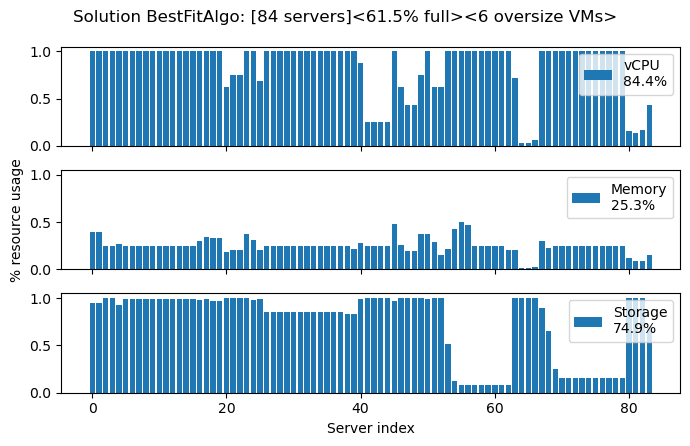


Oversize VMs:
     vCPU  Memory  Storage  Class  weighted_resources
216  16.0    32.0   2074.0    2.0            0.092634
298   4.0    32.0   3152.0    2.0            0.084043
367   2.0     8.0   4096.0    2.0            0.092293
752   2.0     8.0   4096.0    3.0            0.092293
856   2.0     8.0   4096.0    3.0            0.092293
857   2.0     8.0   4096.0    3.0            0.092293


In [18]:
criterion = ['vCPU', 'Storage', 'Memory']
sorted_vms = data.vm_data.sort_values(criterion, ascending=False)
best_fit = BestFitAlgo(criterion=criterion)
solution = best_fit.solve(sorted_vms, data.server_data, scarcity_ratio)
solution.display()

# 2) Case where we can split VMs over many servers
We adapt the first-fit alorithm, except that if a VM doesn't fit in a server, we can split it to host part of it in the current server and keep the remainder for another server.

We remove the oversize VMs so that we can compare the results with the previous algorithms

In [44]:
vms_not_oversize = data.vm_data[data.vm_data['Storage'] <= 2048.0]

858it [00:01, 523.10it/s]


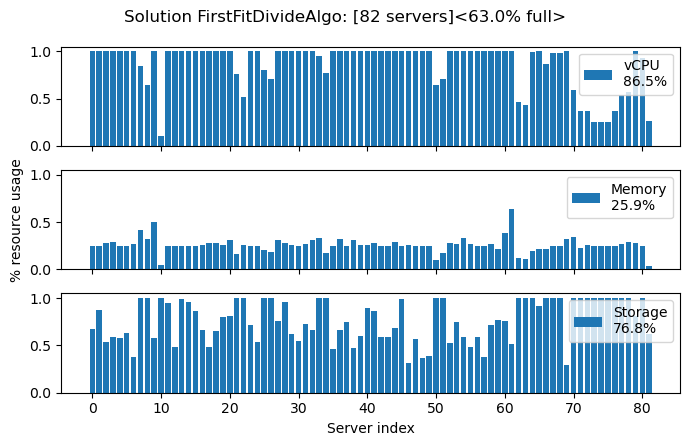

In [47]:
first_fit_divide = FirstFitDivideAlgo()
solution = first_fit_divide.solve(vms_not_oversize, data.server_data)
solution.display()

/Users/amrictrudel/Documents/Repos/OR_VM_placement/vm_placement/data_handling/sorting.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weighted_resources'] = weighted_resources
858it [00:01, 446.10it/s]


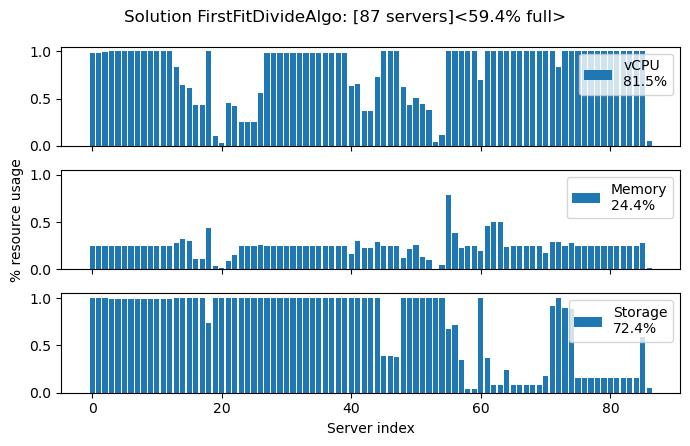

In [54]:
sorted_vms_not_oversize = sort_by_scarcity_ratio(vms_not_oversize, scarcity_ratio)
first_fit_divide = FirstFitDivideAlgo()
solution = first_fit_divide.solve(sorted_vms_not_oversize, data.server_data)
solution.display()

# Other Ideas
## Clustering
We can cluster th VMs and find out if they belong go specific groups

In [39]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(data.vm_data[resource_columns])
kmeans.cluster_centers_

array([[3.14424411e+00, 7.42024965e+00, 3.38794730e+01],
       [1.65869565e+01, 4.01639130e+01, 7.72159638e+02],
       [2.40000000e+00, 1.28000000e+01, 3.90720000e+03]])

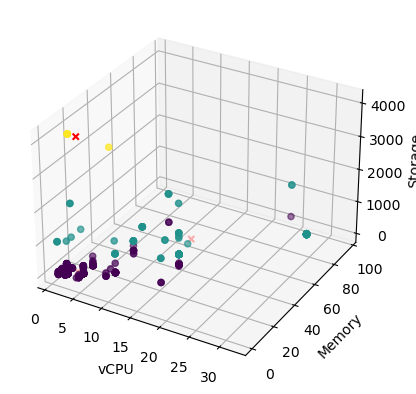

In [40]:
import matplotlib.pyplot as plt

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data points
ax.scatter(data.vm_data['vCPU'], data.vm_data['Memory'], data.vm_data['Storage'],
           c=kmeans.labels_)

ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], c='red', marker='x')
# Set axis labels
ax.set_xlabel('vCPU')
ax.set_ylabel('Memory')
ax.set_zlabel('Storage')

# Show plot
plt.show()

## PCA

In [74]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_resource_features = scaler.fit_transform(vms_not_oversize[resource_columns])

pca = PCA(n_components=1)
principal_component = pca.fit_transform(scaled_resource_features)
print(pca.components_)

[[0.70556614 0.56442318 0.42848908]]


Sorting the VMs with this new component

In [75]:
vms_sorted_by_pca = vms_not_oversize.copy()
vms_sorted_by_pca.loc[:, 'pca'] = principal_component
vms_sorted_by_pca = vms_sorted_by_pca.sort_values('pca', ascending=False)

### Using it for First Fit Divide

858it [00:01, 461.43it/s]


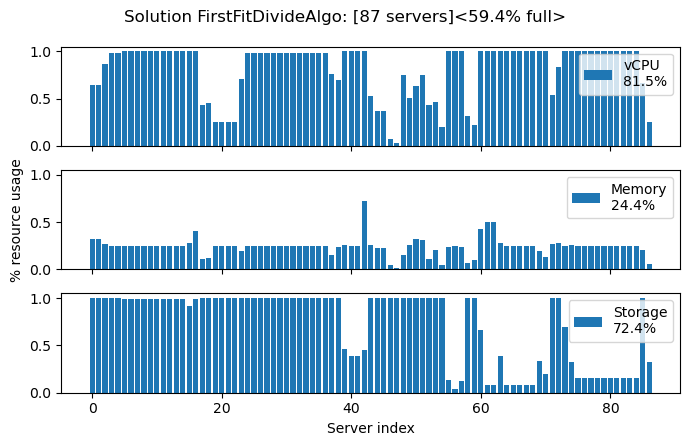

In [70]:
first_fit_divide = FirstFitDivideAlgo()
solution = first_fit_divide.solve(vms_sorted_by_pca, data.server_data)
solution.display()

### Using it for Best Fit

In [78]:
# Calculating PCA of the server
server_data_pca = data.server_data.copy()
server_data_pca.loc[:,'pca'] = pca.transform(scaler.transform(data.server_data))

858it [00:46, 18.33it/s]


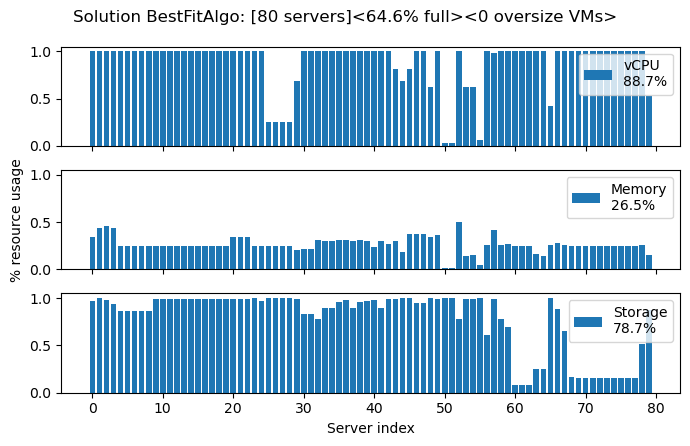


Oversize VMs:
Empty DataFrame
Columns: [vCPU, Memory, Storage, Class, weighted_resources, pca]
Index: []


In [81]:
best_fit = BestFitAlgo(criterion='Storage')
solution = best_fit.solve(vms_sorted_by_pca, data.server_data, scarcity_ratio)
solution.display()

# Conclusion
It seems like the lowest possible number of server for all algorithms that were tried is 80. It also seems that in the data, the VMs were placed in an order that is optimal for this specific server configuration, as the First-Fit without sorting got the best solution directly.

The code is made so that it can be used for a situation where the servers differ in capacities. This is left for further development.